In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import DifferentialActionModelPointMass

In [2]:
nx = 4
nu = 2
T = 40
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs0 = Obstacle(10, 8, 2, 1, 'Obs0')
obs1 = Obstacle(9, 7, 1, 1.5, 'Obs1')
obs2 = Obstacle(6, 6, 1, 1.5, 'Obs2')
obs3 = Obstacle(7, 9, 1, 1.5, 'Obs3')
obs4 = Obstacle(4, 4, 1, 1.5, 'Obs4')
obs5 = Obstacle(3.5, 6, 1, 1.5, 'Obs5')
obs6 = Obstacle(7.5, 3, 1, 1.5, 'Obs6')
obs7 = Obstacle(5, 1, 1, 1.5, 'Obs7')
obs_set = [obs1, obs2, obs3, obs4, obs5, obs6, obs7]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)
cost_set.add_cost(obs4)
cost_set.add_cost(obs5)
cost_set.add_cost(obs6)
cost_set.add_cost(obs7)

nr = cost_set.nr

In [3]:
# Desired Running and Terminal Model
w_run_possibles = np.array([10, 1., 1., 2000, 1000, 2000, 2000, 2000, 1000, 1000])
w_term_possibles = np.array([5000, 1., 1., 1000, 1000, 1000, 500, 0, 1000, 1000])
w_run = w_run_possibles[:nr]
w_term = w_term_possibles[:nr]
obs_set = obs_set[:nr]
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()
w_run = w_des[:nr]; w_term = w_des[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_opt = mim_solvers.SolverSQP(problem)
sqp_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_opt.with_callbacks=True
sqp_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_opt.solve(xs_init, us_init, 500)
xs_optimal = np.stack(sqp_opt.xs.tolist().copy())
us_optimal = np.stack(sqp_opt.us.tolist().copy())
print(done)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.00400e+02  1.00400e+02  3.47335e+01  1.0000  0.00000e+00  9.98748e+00
   2  8.17946e-01  8.17946e-01  1.37966e-01  1.0000  1.90126e-14  2.91642e-02
   3  8.15328e-01  8.15328e-01  1.32913e-01  1.0000  2.36795e-10  1.26526e-02
   4  8.13057e-01  8.13057e-01  1.37915e-01  1.0000  2.30353e-10  7.97546e-03
   5  8.10559e-01  8.10559e-01  1.44528e-01  1.0000  2.69730e-10  6.82306e-03
   6  8.07756e-01  8.07756e-01  1.14854e+01  1.0000  2.84047e-10  6.63948e-01
   7  7.73736e-01  7.73736e-01  9.01264e-01  1.0000  2.13555e-08  3.07915e-01
   8  6.94836e-01  6.94836e-01  1.24794e+00  1.0000  1.37382e-09  7.93185e-02
   9  6.65201e-01  6.65201e-01  4.42823e+00  1.0000  2.54428e-09  4.34868e-02
  10  6.14504e-01  6.14504e-01  2.03513e+00  1.0000  7.48806e-09  2.29177e-02
iter     merit         cost         grad      step    ||gaps||        KKT
  11  6.03425e-01  6.03425e-01  1.55912e+00  1.0000  3.82753e-09  4.5309

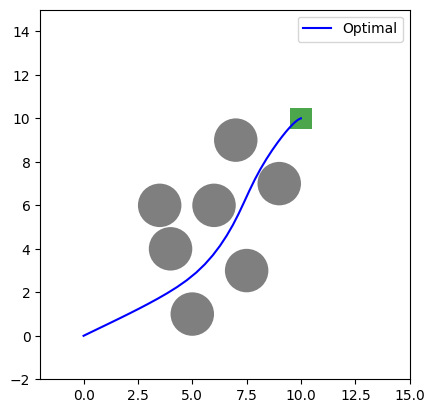

In [4]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(np.vstack(xs_optimal), obs_set, target_high, label='Optimal', linemap = 'b')

In [5]:
# Bad Running and Terminal Model
w_bad = np.zeros_like(w_des)
w_run = w_bad[:nr]
w_term = w_bad[nr:]

PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_non_opt = mim_solvers.SolverSQP(problem)
sqp_non_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_non_opt.with_callbacks=True
sqp_non_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_non_opt.solve(xs_init, us_init, 500)
xs_non_optimal = np.stack(sqp_non_opt.xs.tolist().copy())
us_non_optimal = np.stack(sqp_non_opt.us.tolist().copy())
print(done)

iter     merit         cost         grad      step    ||gaps||        KKT
 END  0.00000e+00  0.00000e+00  0.00000e+00   ----   0.00000e+00  0.00000e+00
True


In [6]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())
# plot_1_traj(np.vstack(xs_non_optimal), obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [54]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    # x /= np.linalg.norm(x)
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    opt_traj_cost = cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt)
    num += np.exp(-opt_traj_cost)
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        non_opt_traj_cost = cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt)
        o = np.exp(opt_traj_cost - non_opt_traj_cost)**2
        den += o*np.exp(-non_opt_traj_cost)
        # den += np.exp(-non_opt_traj_cost)
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

def fcn_w_2D(x, cost_set, xs_optimal, us_optimal, xs_non_optimal, us_non_optimal, dt, Lambda = 0.001):
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    den += np.exp(-cost_set.traj_cost(xs_non_optimal, us_non_optimal, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

In [55]:
dt = timeStep
Lambda = 0.0001
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 2, 'iprint': -1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10

e_prev = np.inf
w0 = w_bad
max_set_size = 20
it = 0
it_max = max_set_size + 1
Es = []
xs = []
us = []
ws = []
xs_non_optimal_set = []
us_non_optimal_set = []
xs_non_optimal_set.append(np.vstack(xs_non_optimal).copy())
us_non_optimal_set.append(np.vstack(us_non_optimal).copy())
xs.append(np.vstack(xs_non_optimal).copy())
us.append(np.vstack(us_non_optimal).copy())
ws.append(w_bad)
stochastic = False
loop_tol = 0.001
e = 1
while e > loop_tol and it < it_max:
    res = minimize(fcn_w, 
                   w0, 
                   args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda), 
                   bounds=bnds, 
                   method='L-BFGS-B', 
                   tol = tol,
                   options=options)
    w_loop = res.x.copy()
    w_loop /= np.max(w_loop)
    w_run = w_loop[:nr]
    w_term = w_loop[nr:]
    for i in range(T):
        sqp_non_opt.problem.runningModels[i].differential.model.costWeights = w_run
    sqp_non_opt.problem.terminalModel.differential.model.costWeights = w_term
    # done = sqp_non_opt.solve(xs_non_optimal.tolist(), us_non_optimal.tolist(), 100)
    sqp_non_opt.with_callbacks=False
    xs_init = [sqp_non_opt.xs.copy()[i] for i in range(T+1)]
    us_init = [sqp_non_opt.us.copy()[i] for i in range(T)]
    done = sqp_non_opt.solve(xs_init, us_init, 5)
    if it > 0:
        e = np.abs(cost_set.traj_cost(xs_optimal, us_optimal, w_run, w_term, dt)
                   - cost_set.traj_cost(sqp_non_opt.xs.copy(), sqp_non_opt.us.copy(), w_run, w_term, dt))
    # us_non_optimal = sqp_non_opt.us.copy()+np.random.normal(0.0,2.0,np.stack(us_non_optimal.tolist()).shape)
    # xs_non_optimal = np.stack(problem.rollout([us_non_optimal[i] for i in range(T)]))
    xs.append(np.vstack(sqp_non_opt.xs.copy()).copy())
    us.append(np.vstack(sqp_non_opt.us.copy()).copy())
    # us.append(np.vstack(sqp_non_opt.us.copy()).copy()+np.random.normal(0.0,5.0,np.stack(us_non_optimal.tolist()).shape))
    ws.append(w_loop.copy())
    Es.append(e)
    if len(xs_non_optimal_set) <= max_set_size:
        xs_non_optimal_set = xs
        us_non_optimal_set = us
    else:
        if not stochastic:
            xs_non_optimal_set = xs[-max_set_size:]
            us_non_optimal_set = us[-max_set_size:]
        else:
            xs_non_optimal_set = random.choices(xs, k=max_set_size)
            us_non_optimal_set = random.choices(us, k=max_set_size)
        
    w0 = w_loop.copy()
    if it > 0:
        print('Error: ', e, 
              'Optimal Difference: ', 
              (cost_set.traj_cost(sqp_non_opt.xs.copy(), sqp_non_opt.us.copy(), w_des[:nr], w_des[nr:], dt)-
              cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], dt))**2)
    it += 1

print(res)
w_irl = res.x/np.max(res.x)

Error:  38.405663987617245 Optimal Difference:  36.622146491812764
Error:  3.376598760922734 Optimal Difference:  0.2729913181883806
Error:  0.20321413284257453 Optimal Difference:  0.02727195812849308
Error:  0.443164605102374 Optimal Difference:  0.01332118086167815
Error:  0.9357683949980595 Optimal Difference:  0.04527572201217708
Error:  0.9659438531099429 Optimal Difference:  0.03525307060259448
Error:  0.12999030249371574 Optimal Difference:  0.006751348630352661
Error:  0.13601173162158653 Optimal Difference:  0.0011646340646041696
Error:  0.14752848161753063 Optimal Difference:  0.003708822780151731
Error:  0.15104181251669946 Optimal Difference:  0.001114933122303593
Error:  0.06939615550087258 Optimal Difference:  0.0017182150989700933
Error:  0.061153025575840125 Optimal Difference:  0.0003775925953651823
Error:  0.2294556543091404 Optimal Difference:  0.12289954851812193
Error:  0.10541456402785432 Optimal Difference:  0.0005750589432233622
Error:  0.04229647231837874 Opti

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


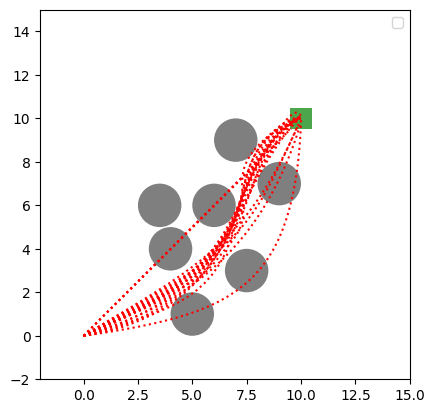

In [56]:
plot_1_set(xs, obs_set, target_high, label='', linemap_traj='r:', linemap_set='r:')

In [57]:
# n = 0
# plot_1_set([xs_optimal, xs[n]], obs_set, target_high, label='', linemap_traj='g:', linemap_set='b')
# print(np.abs(cost_set.traj_cost(xs_optimal, us_optimal, ws[n][:nr], ws[n][nr:], dt) -
#      cost_set.traj_cost(xs[n], us[n], ws[n][:nr], ws[n][nr:], dt)))

In [58]:
w_irl = res.x/np.max(res.x)
w_irl /= np.max(w_irl)
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.002 IRL:  0.0019299602488315932
Terminal ||  Desired:  1.0 IRL:  0.9190285442544783

XReg :
Running ||  Desired:  0.0002 IRL:  0.0
Terminal ||  Desired:  0.0002 IRL:  0.0

UReg :
Running ||  Desired:  0.0002 IRL:  0.0005255891325436647
Terminal ||  Desired:  0.0002 IRL:  0.0

Obs1 :
Running ||  Desired:  0.4 IRL:  1.0
Terminal ||  Desired:  0.2 IRL:  0.028017081384985733

Obs2 :
Running ||  Desired:  0.2 IRL:  0.7473951491321416
Terminal ||  Desired:  0.2 IRL:  0.0

Obs3 :
Running ||  Desired:  0.4 IRL:  0.800349738186118
Terminal ||  Desired:  0.2 IRL:  0.028016811029816763

Obs4 :
Running ||  Desired:  0.4 IRL:  0.668950224462172
Terminal ||  Desired:  0.1 IRL:  0.0

Obs5 :
Running ||  Desired:  0.4 IRL:  0.06963389334495206
Terminal ||  Desired:  0.0 IRL:  0.0

Obs6 :
Running ||  Desired:  0.2 IRL:  0.4042779309162187
Terminal ||  Desired:  0.2 IRL:  0.0

Obs7 :
Running ||  Desired:  0.2 IRL:  0.6076774212527398
Terminal ||  Desired:  0.2 IRL:  0

In [59]:
print('Desired:                 ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda)) 
print('IRL:                     ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda))
print('')
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))
print('with IRL Weight:         ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))
print('')
print('IRL Trajectory Cost:     ', cost_set.traj_cost(xs[-1], us[-1], w_irl[:nr], w_irl[nr:], timeStep))
print('with Desired Weight:     ', cost_set.traj_cost(xs[-1], us[-1], w_des[:nr], w_des[nr:], timeStep))

Desired:                  2.764505177997012
IRL:                      2.5910023247385436

Desired Trajectory Cost:  0.5839224512110999
with IRL Weight:          0.9315450354543677

IRL Trajectory Cost:      0.912858127694379
with Desired Weight:      0.592612316825144


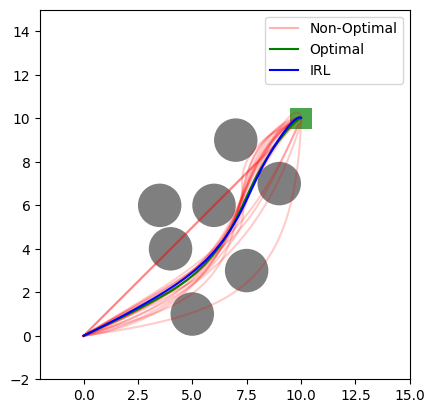

In [60]:
plot_results(xs_optimal, xs[:-1], xs[-1], obs_set, target_high)

In [89]:
# Testing
w_run = w_irl[:nr]
w_term = w_irl[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
# x0 = np.array([7.5, 5.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp = mim_solvers.SolverSQP(problem)
sqp.setCallbacks([crocoddyl.CallbackVerbose()])
sqp.with_callbacks=True
sqp.termination_tolerance = 1e-5
# xs_init = [x0 for i in range(T+1)]
# us_init = [u0 for i in range(T)]
xs_init = [xs_optimal[i] for i in range(T+1)]
us_init = [us_optimal[i] for i in range(T)]

# Solving this problem
done = sqp.solve(xs_init, us_init, 500)
xs_output = np.stack(sqp.xs.tolist().copy())
us_output = np.stack(sqp.us.tolist().copy())

iter     merit         cost         grad      step    ||gaps||        KKT
   1  9.31545e-01  9.31545e-01  7.20286e+00  1.0000  5.69913e-11  3.41531e-02
   2  9.14352e-01  9.14352e-01  2.77654e-01  1.0000  1.42731e-08  2.13134e-03
   3  9.14087e-01  9.14087e-01  2.07929e-01  1.0000  5.53485e-10  8.99631e-04
   4  9.13940e-01  9.13940e-01  1.79680e-01  1.0000  4.15422e-10  9.73924e-04
   5  9.13846e-01  9.13846e-01  1.74211e-01  1.0000  3.31071e-10  1.14999e-03
   6  9.13777e-01  9.13777e-01  1.81278e-01  1.0000  4.24452e-10  1.40695e-03
   7  9.13715e-01  9.13715e-01  4.77846e+00  0.5000  3.46451e-10  4.08129e-02
   8  9.13059e-01  9.13059e-01  5.11794e-01  1.0000  4.42663e-09  1.82316e-03
   9  9.12872e-01  9.12872e-01  4.11611e-01  1.0000  1.23659e-09  2.59855e-03
  10  9.12843e-01  9.12843e-01  3.25253e-02  1.0000  8.05914e-10  2.30392e-04
iter     merit         cost         grad      step    ||gaps||        KKT
 END  9.12843e-01  9.12843e-01  4.72878e-04   ----   5.80454e-11  3.6680

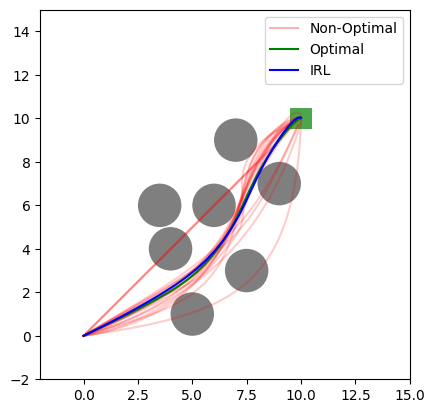

In [90]:
plot_results(xs_optimal, xs[:-1], xs_output, obs_set, target_high)

In [91]:
# creating sets
all_set_x = []
all_set_u = []
training_set_x = []
training_set_u = []

all_set_x.append(xs[-1]); all_set_x.append(xs_optimal); training_set_x.append(xs_optimal)
all_set_u.append(us[-1]); all_set_u.append(us_optimal); training_set_u.append(us_optimal)

for X, U in zip(xs_non_optimal_set, us_non_optimal_set):
    all_set_x.append(X); training_set_x.append(X)
    all_set_u.append(U); training_set_u.append(U)

In [92]:
P_irl = distributions(cost_set, training_set_x, training_set_u, w_irl[:nr], w_irl[nr:], dt)
P_des = distributions(cost_set, training_set_x, training_set_u, w_des[:nr], w_des[nr:], dt)

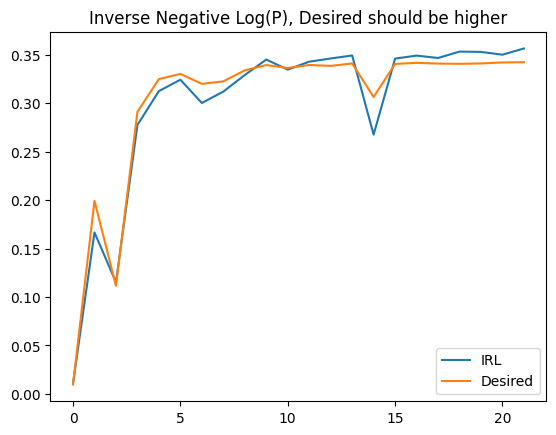

In [93]:
plt.plot(-1/np.log(P_irl[1:]),label='IRL')
plt.plot(-1/np.log(P_des[1:]),label='Desired')
plt.legend()
plt.title('Inverse Negative Log(P), Desired should be higher')
plt.show()